In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list

#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

# Import my own functions
from desc.fns_simp import (#data_eval, 
                           #_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           #plot_xy,
                           #surf_int
                          )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

In [3]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization_fd,
    CoilThicknessRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [4]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [5]:
G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [6]:
eq = eq_QA

R0 = 1.0
a = 0.3

surf = FourierRZToroidalSurface(R_lmn=[R0,a], 
                                Z_lmn=[-a],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP
                               )
surf.change_resolution(N=eq.N)

eq.axis.R_n = eq_QA.axis.R_n + 0.5*(eq_QH.axis.R_n - eq_QA.axis.R_n)
eq.axis.Z_n = eq_QA.axis.Z_n + 0.5*(eq_QH.axis.Z_n - eq_QA.axis.Z_n)

######
for coef, mode in zip(eq.axis.R_n, eq.axis.R_basis.modes):
    n = mode[-1]
    surf.R_lmn=surf.R_lmn.at[surf.R_basis.get_idx(M=0,N=n)].set( coef)
for coef, mode in zip(eq.axis.Z_n, eq.axis.Z_basis.modes):
    n = mode[-1]
    surf.Z_lmn=surf.Z_lmn.at[surf.Z_basis.get_idx(M=0,N=n)].set( coef)

In [7]:
surf1 = surf

surf1.change_resolution(M=8,N=6)

#surf1.change_resolution(M=4,N=4)

# Generate a Surface Current field for RQA
surf1 = FourierCurrentPotentialField.from_surface(surf1,
                                                  M_Phi=8,
                                                  N_Phi=8,
                                                  sym_Phi=False, 
                                                  I=0, 
                                                  G=G_QA)

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
surf2.G = G_QH

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

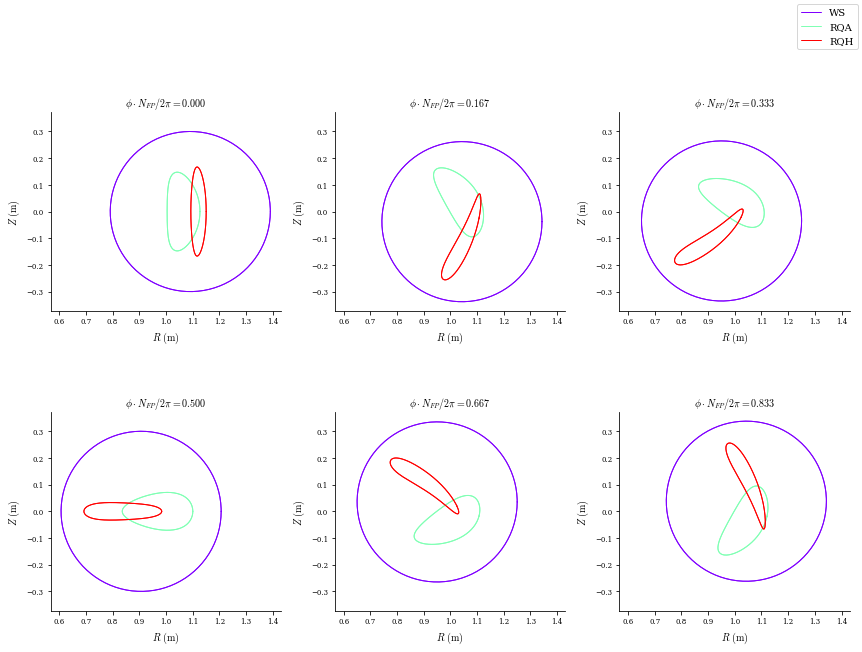

In [8]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [9]:
surf1.I

0.0

In [10]:
surf2.I

0.0

In [11]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [12]:
# Grids
Megrid = 10
Negrid = 10

Msgrid = 25
Nsgrid = 13

egrid = LinearGrid(M=Megrid,N=Negrid,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   NFP=eq.NFP,
                   sym=False) 

In [13]:
surf1.NFP

3

In [14]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [15]:
flux_QA = QuadraticFlux(eq_QA,
                        surf1,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 1e0,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,
                        surf2,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 1e1,
                        name="Bn error  eq_QH")

In [16]:
# Distance target
min_QA = 0.1
max_QA = 0.35

min_QH = 0.1
max_QH = 0.25#1#0.28

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 10,
    #use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf2,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    #use_signed_distance=True,
    weight = 20,
    name="distance error  RQH"
)

In [17]:
surf_curr_reg_QA = SurfaceCurrentRegularization(
    surf1,
    #target=None,
    #bounds=None,
    weight=1e0,
    #normalize=True,
    #normalize_target=True,
    #loss_function=None,
    #deriv_mode="auto",
    source_grid=sgrid,
    name="surface-current-regularization QA",
    )

surf_curr_reg_QH = SurfaceCurrentRegularization(
    surf2,
    #target=None,
    #bounds=None,
    weight=1e0,
    #normalize=True,
    #normalize_target=True,
    #loss_function=None,
    #deriv_mode="auto",
    source_grid=sgrid,
    name="surface-current-regularization QA",
    )

In [18]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf1,
    #target = mean_curv,
    bounds = (-1,1),
    weight=1e-2,
    normalize=True,
    normalize_target=True,
    deriv_mode="auto",
    grid=sgrid,
    name="Mean curvature",
)

In [19]:
obj_prin_curv = PrincipalCurvature(surf1,
        #target=None,
        bounds=(-15,-10),
        weight=2e0,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [20]:
Jmax = 5e7 # max current density 50 MA/m2
tmax = 2e-1 # max thickness desired for coils: 10 cm

obj_thickness_QA = bRegularization_fd(surf1,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 2e-6,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QA",
                                              )

obj_thickness_QH = bRegularization_fd(surf2,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 1e-6,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QH",
                                              )

In [21]:
obj = ObjectiveFunction((flux_QA,
                         flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         #obj_mean_curv,
                         #obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         obj_thickness_QA,
                         obj_thickness_QH,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    FixParameters(surf2,{"G":True,}),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [22]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [23]:
# Run optimization
(surf1, surf2),_ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=40,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 options={"initial_trust_radius":np.inf})

Building objective: Bn error  eq_QA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 1.21 sec

Building objective: Bn error  eq_QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 45.1 ms

Building objective: distance error  RQA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 211 ms

Building objective: distance error  RQH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 34.8 ms

Building objective: Coil Thickness Regularization: QA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 53.7 ms

Building objective: Coil Thickness Regularization: QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 53.4 ms

Timer: Objective build = 2.04 sec

Building objective: fixed parameters

Building objective: fixed parameters

Building objective: shared parameters

Timer: Objective build = 68.1 ms

Timer: Linear constraint projection build = 1.74 sec

Number of parameters: 801

Number of objectives: 6390

Timer: Initializing the optimization = 3.94 sec


Starting optimization

Using method: lsq-exact

2024-11-14 20:26:24.507966: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below 56.42GiB (60586658226 bytes) by rematerialization; only reduced to 56.80GiB (60987195770 bytes), down from 56.88GiB (61070719154 bytes) originally


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          3.819e+04                                    1.379e+05   

       1              6          3.735e+04      8.424e+02      2.730e+03      1.348e+05   

       2              7          3.639e+04      9.616e+02      1.383e+03      1.298e+05   

       3              8          3.467e+04      1.719e+03      2.805e+03      4.470e+05   

       4              9          3.385e+04      8.181e+02      7.965e+02      1.198e+05   

       5             11          3.324e+04      6.119e+02      7.073e+02      1.172e+05   

       6             12          3.220e+04      1.044e+03      1.598e+03      1.264e+05   

       7             13          3.030e+04      1.901e+03      3.421e+03      1.076e+05   

       8             14          2.696e+04      3.332e+03      7.539e+03      9.396e+04   

       9             15          2.196e+04      5.006e+03      1.802e+04      2.599e+07   

      10             16          2.172e+04      2.351e+02      2.298e+02      4.827e+06   

      11             17          2.142e+04      3.012e+02      1.814e+03      7.398e+04   

      12             19          1.959e+04      1.832e+03      1.336e+04      7.181e+04   

      13             20          1.869e+04      8.964e+02      9.753e+03      8.140e+05   

      14             21          1.847e+04      2.285e+02      2.066e+02      4.574e+05   

      15             22          1.839e+04      7.922e+01      3.884e+02      1.831e+05   

      16             23          1.799e+04      3.967e+02      2.905e+03      1.281e+05   

      17             24          1.694e+04      1.054e+03      9.389e+03      2.571e+05   

      18             25          1.687e+04      6.436e+01      6.074e+02      6.299e+04   

      19             26          1.596e+04      9.124e+02      2.083e+04      1.274e+07   

      20             27          1.592e+04      3.693e+01      1.249e+02      3.515e+07   

      21             28          1.561e+04      3.163e+02      1.964e+01      2.413e+07   

      22             29          1.560e+04      8.414e+00      4.044e+01      1.438e+07   

      23             30          1.550e+04      9.673e+01      9.752e+00      1.119e+07   

      24             31          1.536e+04      1.439e+02      2.000e+01      6.135e+06   

      25             33          1.532e+04      3.217e+01      1.063e+01      1.452e+07   

      26             34          1.531e+04      9.235e+00      1.017e+01      6.356e+06   

      27             35          1.530e+04      1.240e+01      2.558e+00      5.384e+06   

      28             36          1.530e+04      5.910e+00      5.340e+00      1.035e+06   

      29             37          1.528e+04      1.804e+01      6.296e+00      4.728e+06   

      30             38          1.527e+04      6.017e+00      4.759e+00      1.268e+07   

      31             40          1.527e+04      2.852e+00      1.161e+00      9.509e+05   

      32             41          1.527e+04      3.581e+00      1.570e+00      4.910e+06   

      33             42          1.526e+04      1.900e+00      1.164e+00      1.237e+07   

      34             43          1.526e+04      2.248e+00      1.160e+00      4.937e+06   

      35             44          1.526e+04      3.842e+00      1.160e+00      1.212e+07   

      36             45          1.526e+04      2.181e-01      1.158e+00      4.963e+06   

      37             46          1.526e+04      1.370e+00      2.893e-01      4.916e+06   

      38             47          1.525e+04      1.328e+00      5.794e-01      4.388e+06   

      39             48          1.525e+04      2.264e+00      5.922e-01      1.192e+07   

      40             51          1.525e+04      2.521e-01      7.219e-02      4.314e+06   

         Current function value: 1.525e+04

         Total delta_x: 9.199e+04

         Iterations: 40

         Function evaluations: 51

         Jacobian evaluations: 41

Timer: Solution time = 4.16 min

Timer: Avg time per step = 6.09 sec

                                                                 Start  -->   End

Total (sum of squares):                                      3.819e+04  -->   1.525e+04, 

Maximum absolute Boundary normal field error:                3.480e-02  -->   3.581e-02 (T m^2)

Minimum absolute Boundary normal field error:                5.724e-17  -->   9.796e-07 (T m^2)

Average absolute Boundary normal field error:                1.035e-02  -->   1.057e-02 (T m^2)

Maximum absolute Boundary normal field error:                3.149e-01  -->   3.241e-01 (normalized)

Minimum absolute Boundary normal field error:                5.181e-16  -->   8.867e-06 (normalized)

Average absolute Boundary normal field error:                9.371e-02  -->   9.566e-02 (normalized)

Maximum absolute Boundary normal field error:                7.822e-02  -->   5.867e-02 (T m^2)

Minimum absolute Boundary normal field error:                5.635e-18  -->   1.896e-05 (T m^2)

Average absolute Boundary normal field error:                2.719e-02  -->   1.741e-02 (T m^2)

Maximum absolute Boundary normal field error:                1.373e+00  -->   1.030e+00 (normalized)

Minimum absolute Boundary normal field error:                9.888e-17  -->   3.327e-04 (normalized)

Average absolute Boundary normal field error:                4.771e-01  -->   3.055e-01 (normalized)

Maximum Plasma-vessel distance:                              3.278e-01  -->   3.364e-01 (m)

Minimum Plasma-vessel distance:                              8.205e-02  -->   6.017e-02 (m)

Average Plasma-vessel distance:                              2.035e-01  -->   1.948e-01 (m)

Maximum Plasma-vessel distance:                              3.189e+00  -->   3.273e+00 (normalized)

Minimum Plasma-vessel distance:                              7.984e-01  -->   5.856e-01 (normalized)

Average Plasma-vessel distance:                              1.980e+00  -->   1.896e+00 (normalized)

Maximum Plasma-vessel distance:                              3.100e-01  -->   2.847e-01 (m)

Minimum Plasma-vessel distance:                              6.337e-02  -->   6.154e-02 (m)

Average Plasma-vessel distance:                              2.016e-01  -->   1.882e-01 (m)

Maximum Plasma-vessel distance:                              3.239e+00  -->   2.974e+00 (normalized)

Minimum Plasma-vessel distance:                              6.619e-01  -->   6.428e-01 (normalized)

Average Plasma-vessel distance:                              2.106e+00  -->   1.966e+00 (normalized)

Maximum Sigma Regularization:                                2.528e+06  -->   9.769e+06 

Minimum Sigma Regularization:                                1.347e+06  -->   1.423e+06 

Average Sigma Regularization:                                1.849e+06  -->   3.930e+06 

Maximum Sigma Regularization:                                2.528e+06  -->   9.769e+06 (normalized)

Minimum Sigma Regularization:                                1.347e+06  -->   1.423e+06 (normalized)

Average Sigma Regularization:                                1.849e+06  -->   3.930e+06 (normalized)

Maximum Sigma Regularization:                                2.616e+06  -->   1.373e+07 

Minimum Sigma Regularization:                                1.393e+06  -->   9.940e+05 

Average Sigma Regularization:                                1.913e+06  -->   4.316e+06 

Maximum Sigma Regularization:                                2.616e+06  -->   1.373e+07 (normalized)

Minimum Sigma Regularization:                                1.393e+06  -->   9.940e+05 (normalized)

Average Sigma Regularization:                                1.913e+06  -->   4.316e+06 (normalized)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

Shared parameters error:                                     0.000e+00  -->   0.000e+00 (~)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

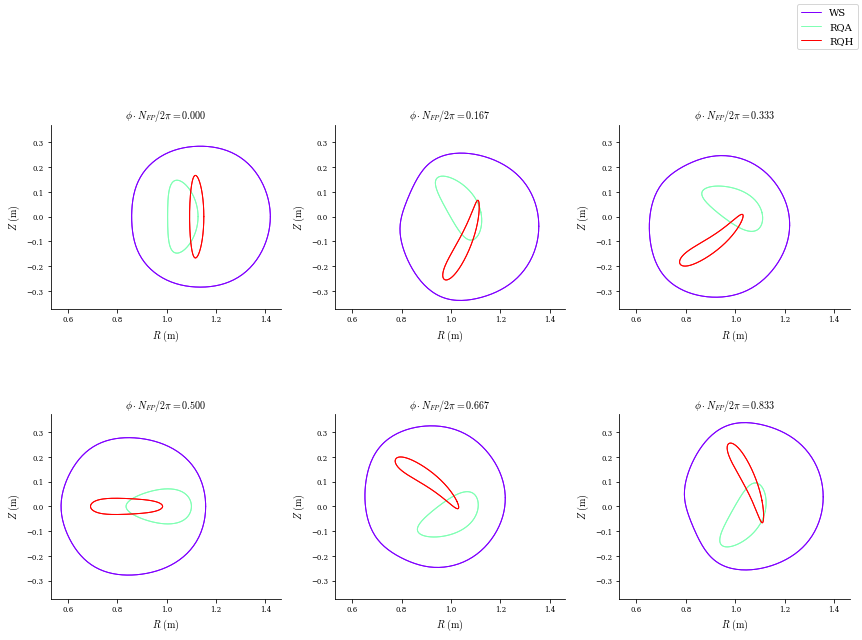

In [24]:
plot_comparison([surf1,
                 eq_QA,
                 eq_QH
                ],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [25]:
#surf1.save("surf_opt.h5")

In [26]:
surf1.I

2.928445127085605e-09

In [27]:
surf2.I

-2069.99116260357

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

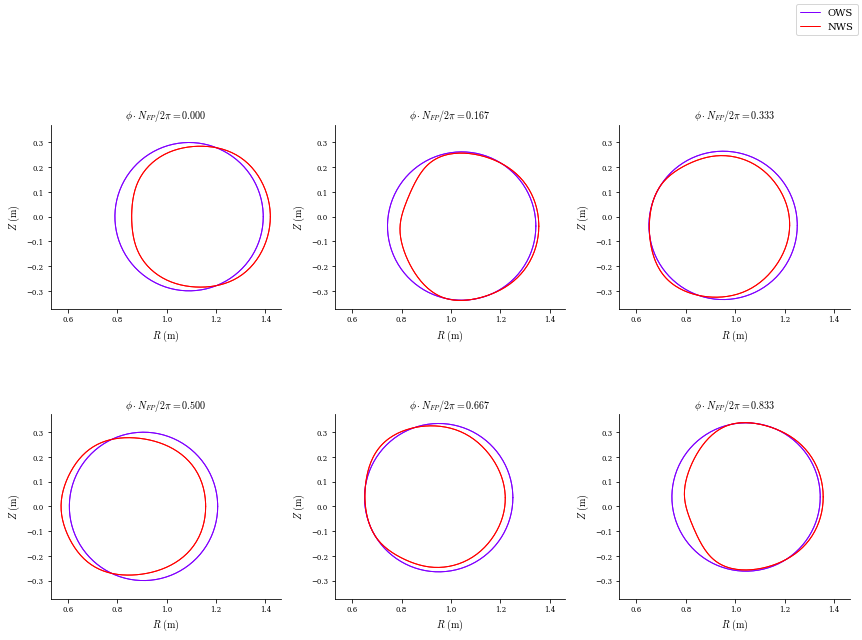

In [28]:
plot_comparison([surf,surf1],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Text(0.5, 1.0, 'K surf2')

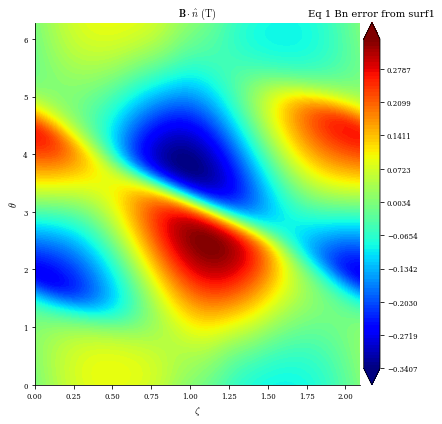

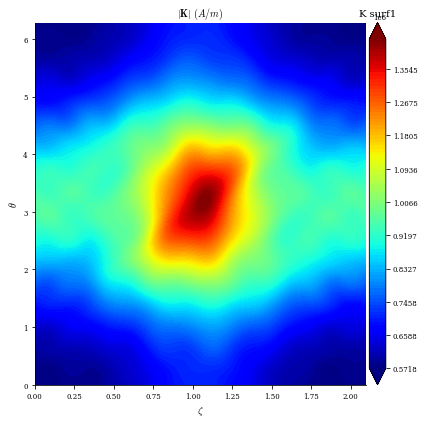

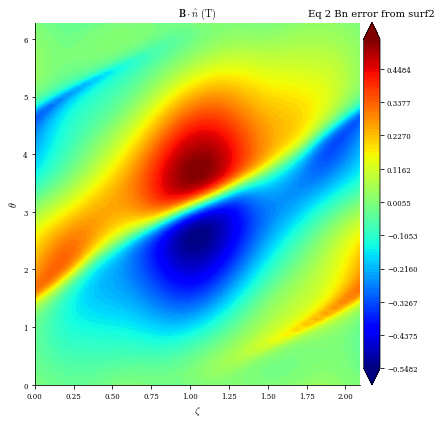

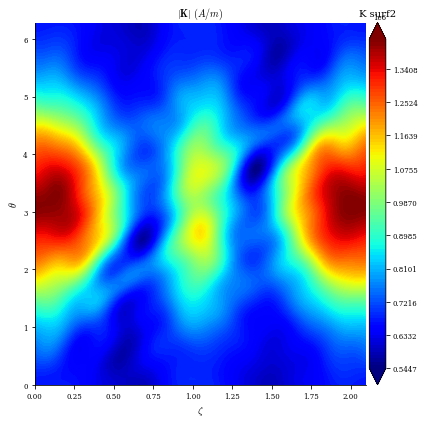

In [29]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=60,N=60,
                                NFP=eq_QA.NFP
                               )
plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "K")
plt.title("K surf1")

plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")

plot_2d(surf2, "K")
plt.title("K surf2")

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

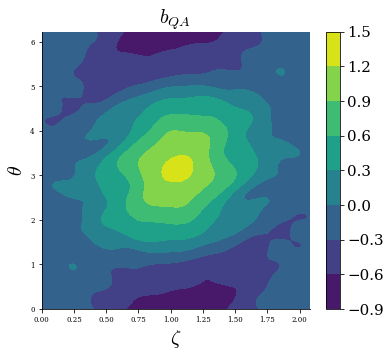

In [30]:
b_QA = surf1.compute("b_s",grid = denser_source_grid)["b_s"]

plot_figure2(b_QA,
            denser_source_grid,
            ''r'$b_{QA}$ '
           )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

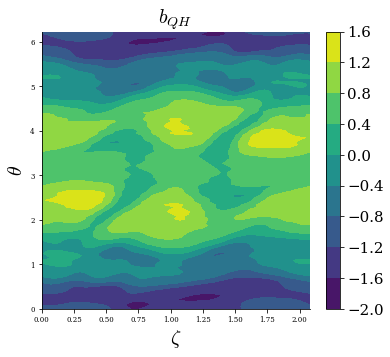

In [31]:
b_QH = surf2.compute("b_s",grid = denser_source_grid)["b_s"]

plot_figure2(b_QH,
            denser_source_grid,
            ''r'$b_{QH}$ '
           )